<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/GAN-is-all-you-need/blob/main/Image%20Generation/MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


In [5]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.83MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

NameError: name 'z_dim' is not defined

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# **TENSORFLOW CODE**

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

# Set random seed for reproducibility
tf.random.set_seed(0)

**This function displays images from a batch of tensors. It normalizes the image data to [0, 1] for proper visualization since the output of the generator uses a tanh activation function, which outputs values in the range [-1, 1].**

In [21]:
def show_tensor_images(image_tensor, num_images=10, size=(28, 28)):
    ''' Function to display a batch of images '''
    # Normalize the images to [0, 1]
    image_tensor = (image_tensor + 1) / 2
    # Reshape the images to 2D for display
    image_tensor = np.reshape(image_tensor, (num_images, *size))
    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1), sharey=True, sharex=True)
    for img, ax in zip(image_tensor, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [11]:
# Generator model
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(z_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [12]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

Noise Generation: A random noise vector is created with dimensions [batch_size, z_dim], where batch_size is the number of images to generate in one step, and z_dim is the dimensionality of the latent space (input to the generator).

Image Generation: The generator model takes the noise vector as input and generates a batch of fake images. The training=True parameter ensures that behaviors like batch normalization or dropout that behave differently during training and inference are correctly applied.

..........................................................


Real Output: The discriminator evaluates the batch of real images (images) from the dataset.

Fake Output: The discriminator also evaluates the batch of fake images generated by the generator.

...........................................................

Generator Loss (gen_loss): This loss measures how well the generator is doing at fooling the discriminator. It is calculated using the discriminator's predictions on the fake images. The goal is to make the discriminator believe these fake images are real (labels are ones).

Discriminator Loss (disc_loss): This loss measures how well the discriminator is doing at distinguishing real images from fake images. It's the sum of the losses for real images (should classify as ones) and fake images (should classify as zeros).

............................................................

Gradient Tapes: TensorFlow uses tf.GradientTape to record operations for automatic differentiation. Here, separate tapes are used for the generator and the discriminator to compute gradients of the respective losses with respect to the model parameters (trainable_variables).

...........................................................

Update Steps: The calculated gradients are applied to update the generator and discriminator weights. This step uses the Adam optimizer (or any other optimizer defined) to adjust the weights in the direction that minimally reduces the respective losses.

Output: The function returns the generated images. This can be useful for visualizing the progress of the generator during training, as these images can be displayed after certain epochs to see how the quality of image generation improves.

In [18]:
# Training step
@tf.function
def train_step(images, generator, discriminator, batch_size, z_dim):
    noise = tf.random.normal([batch_size, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return generated_images

In [19]:
def train(generator, discriminator, dataset, epochs, batch_size, z_dim):
    for epoch in range(epochs):
        for image_batch in dataset:
            generated_images = train_step(image_batch, generator, discriminator, batch_size, z_dim)
        # Display images at the end of each epoch
        print("Displaying generated images at the end of epoch", epoch + 1)
        show_tensor_images(generated_images[:10], num_images=10)



In [16]:
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

# Initialize models
z_dim = 100
generator = build_generator(z_dim)
discriminator = build_discriminator()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Displaying generated images at the end of epoch 1


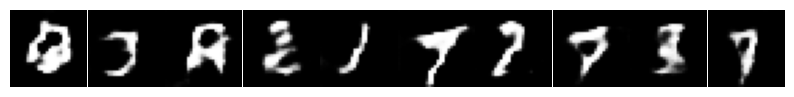

Displaying generated images at the end of epoch 2


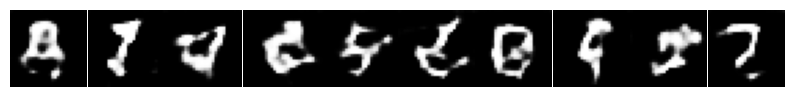

Displaying generated images at the end of epoch 3


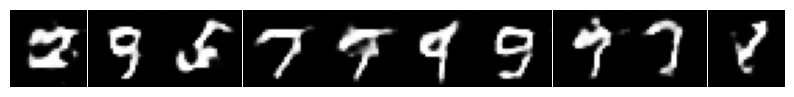

Displaying generated images at the end of epoch 4


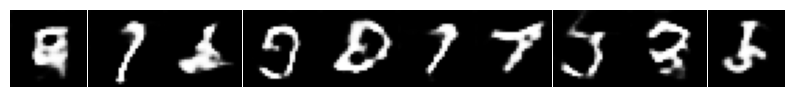

Displaying generated images at the end of epoch 5


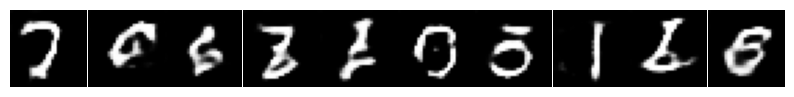

Displaying generated images at the end of epoch 6


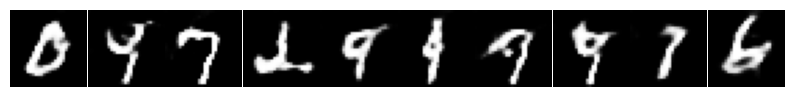

Displaying generated images at the end of epoch 7


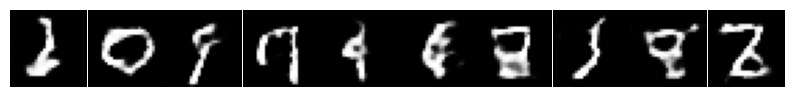

Displaying generated images at the end of epoch 8


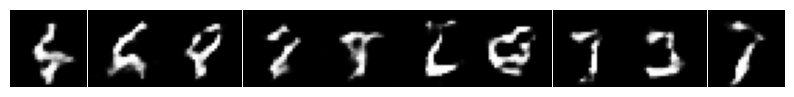

Displaying generated images at the end of epoch 9


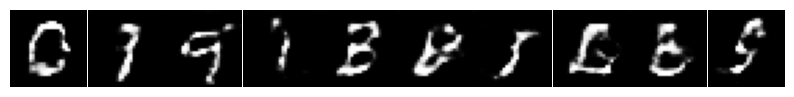

Displaying generated images at the end of epoch 10


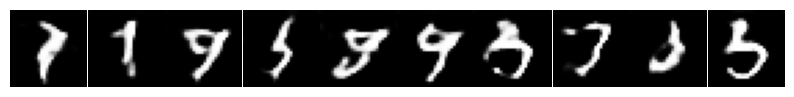

Displaying generated images at the end of epoch 11


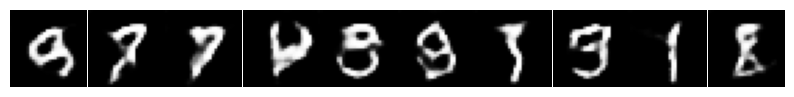

Displaying generated images at the end of epoch 12


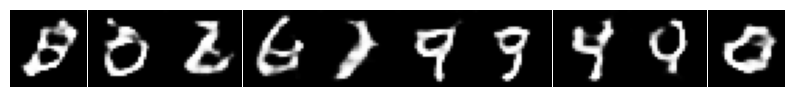

Displaying generated images at the end of epoch 13


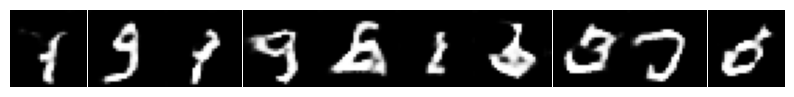

Displaying generated images at the end of epoch 14


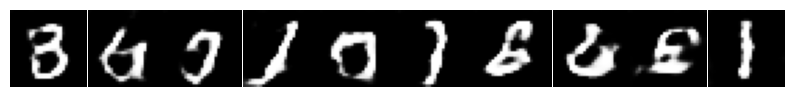

Displaying generated images at the end of epoch 15


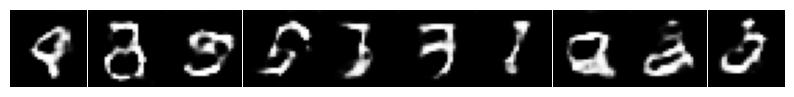

Displaying generated images at the end of epoch 16


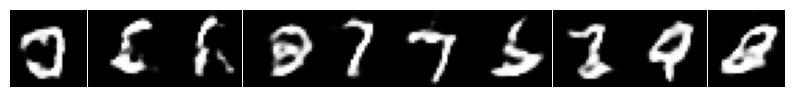

Displaying generated images at the end of epoch 17


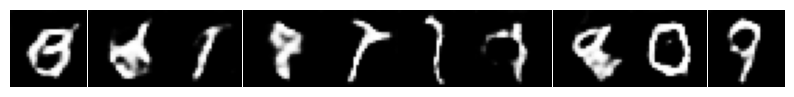

Displaying generated images at the end of epoch 18


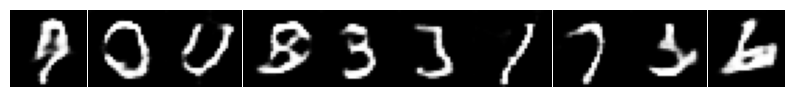

Displaying generated images at the end of epoch 19


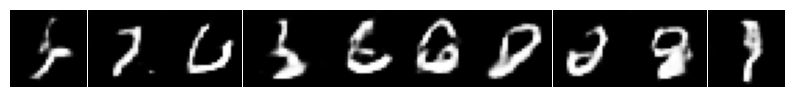

Displaying generated images at the end of epoch 20


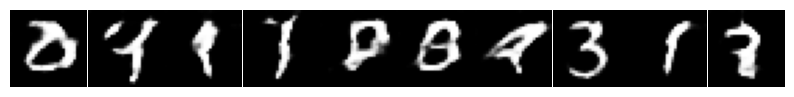

Displaying generated images at the end of epoch 21


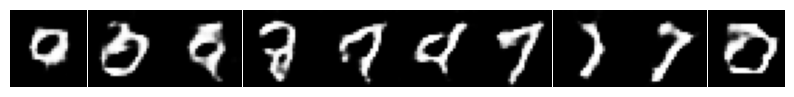

Displaying generated images at the end of epoch 22


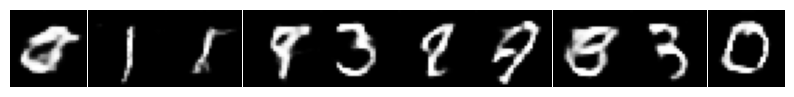

Displaying generated images at the end of epoch 23


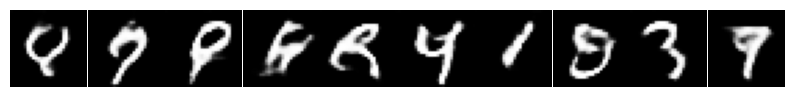

Displaying generated images at the end of epoch 24


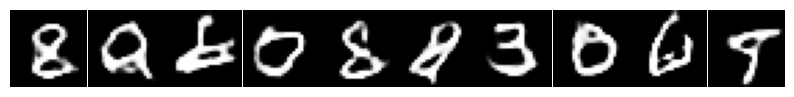

Displaying generated images at the end of epoch 25


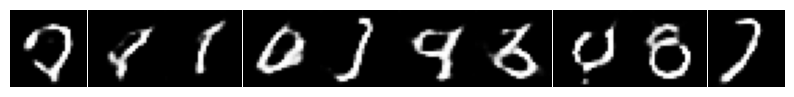

Displaying generated images at the end of epoch 26


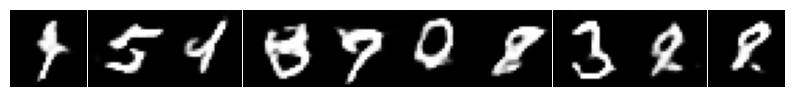

Displaying generated images at the end of epoch 27


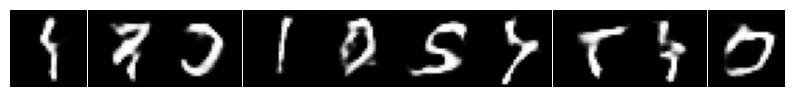

Displaying generated images at the end of epoch 28


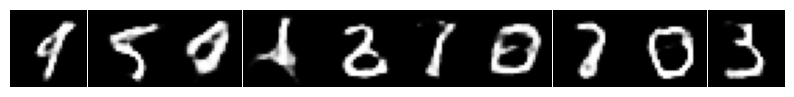

Displaying generated images at the end of epoch 29


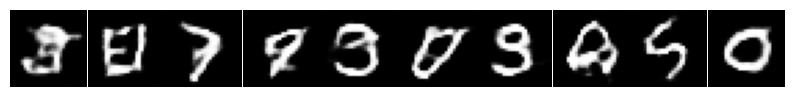

Displaying generated images at the end of epoch 30


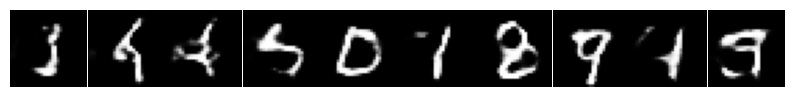

Displaying generated images at the end of epoch 31


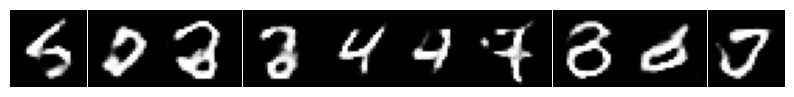

Displaying generated images at the end of epoch 32


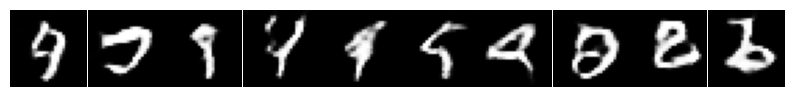

Displaying generated images at the end of epoch 33


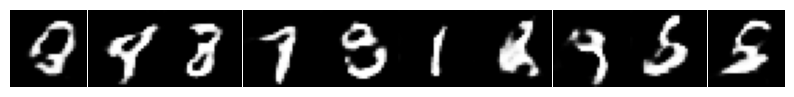

Displaying generated images at the end of epoch 34


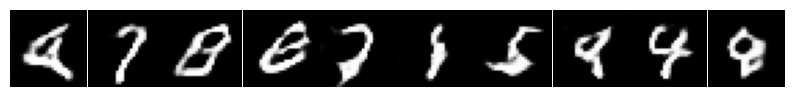

Displaying generated images at the end of epoch 35


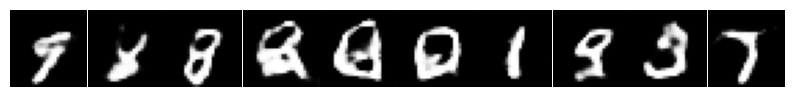

Displaying generated images at the end of epoch 36


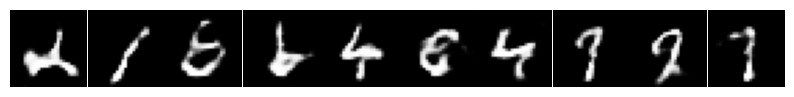

Displaying generated images at the end of epoch 37


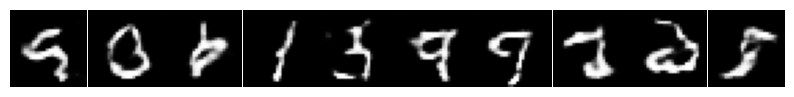

Displaying generated images at the end of epoch 38


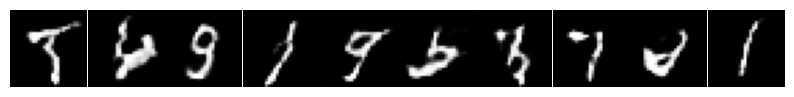

Displaying generated images at the end of epoch 39


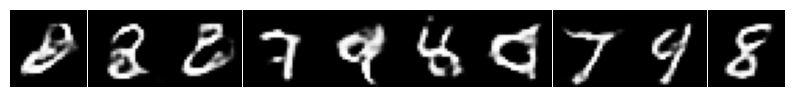

Displaying generated images at the end of epoch 40


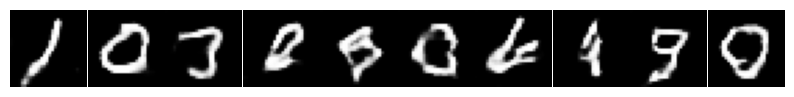

Displaying generated images at the end of epoch 41


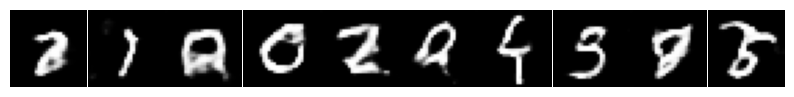

Displaying generated images at the end of epoch 42


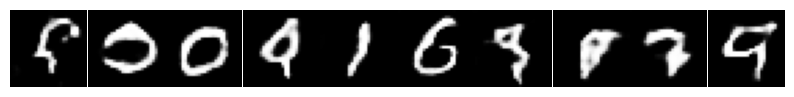

Displaying generated images at the end of epoch 43


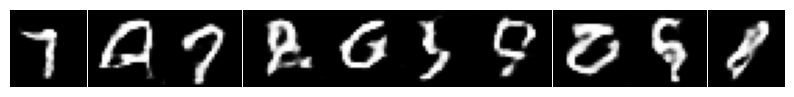

Displaying generated images at the end of epoch 44


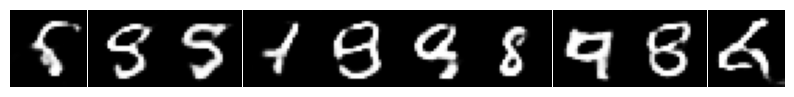

Displaying generated images at the end of epoch 45


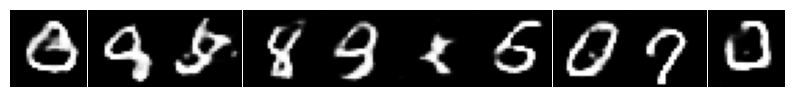

Displaying generated images at the end of epoch 46


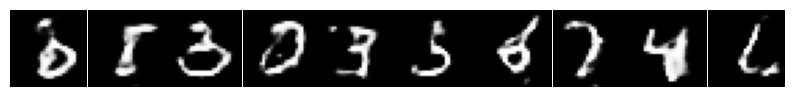

Displaying generated images at the end of epoch 47


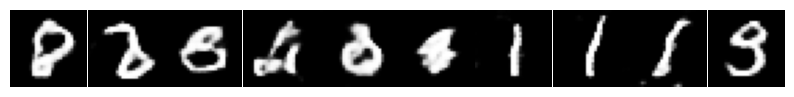

Displaying generated images at the end of epoch 48


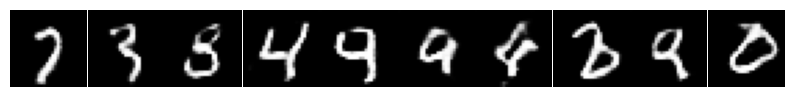

Displaying generated images at the end of epoch 49


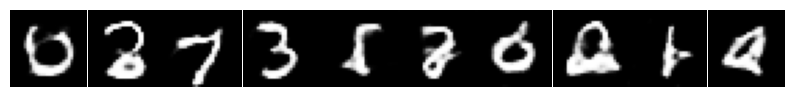

Displaying generated images at the end of epoch 50


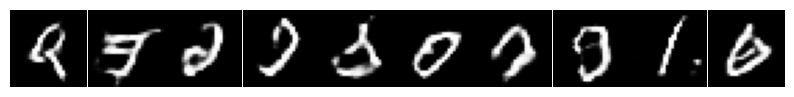

Displaying generated images at the end of epoch 51


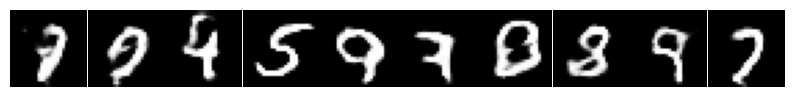

Displaying generated images at the end of epoch 52


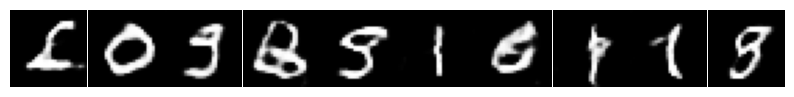

Displaying generated images at the end of epoch 53


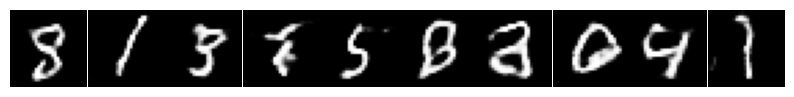

Displaying generated images at the end of epoch 54


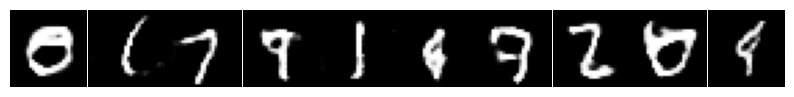

Displaying generated images at the end of epoch 55


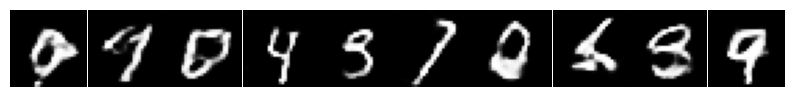

Displaying generated images at the end of epoch 56


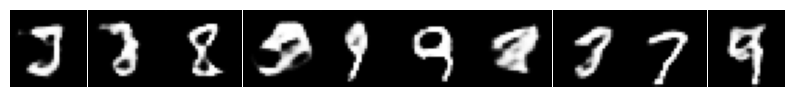

Displaying generated images at the end of epoch 57


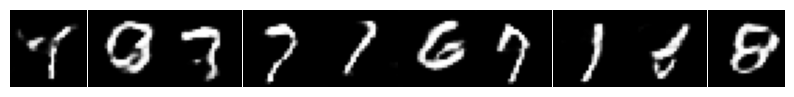

Displaying generated images at the end of epoch 58


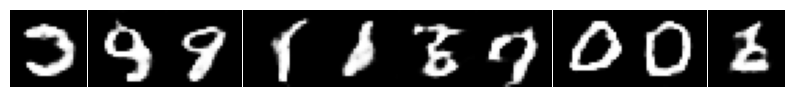

Displaying generated images at the end of epoch 59


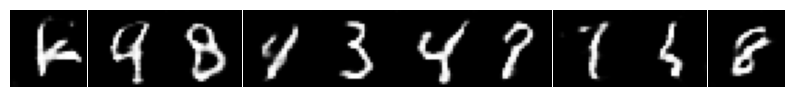

Displaying generated images at the end of epoch 60


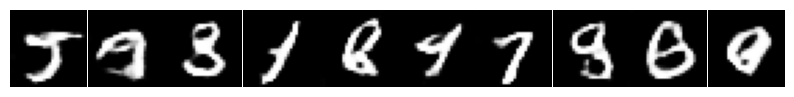

Displaying generated images at the end of epoch 61


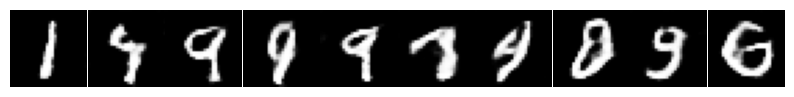

Displaying generated images at the end of epoch 62


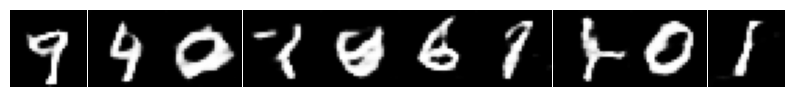

Displaying generated images at the end of epoch 63


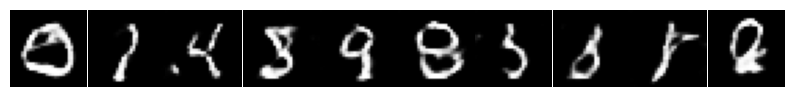

Displaying generated images at the end of epoch 64


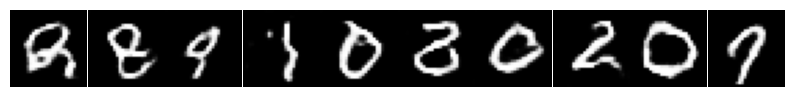

Displaying generated images at the end of epoch 65


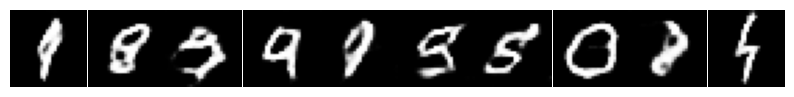

Displaying generated images at the end of epoch 66


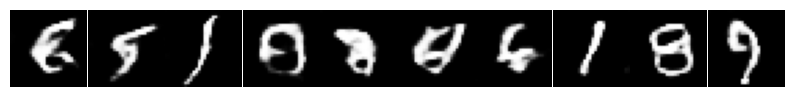

Displaying generated images at the end of epoch 67


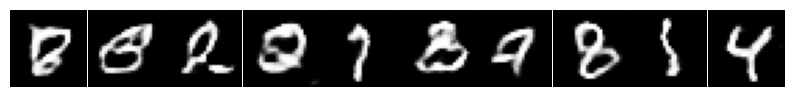

Displaying generated images at the end of epoch 68


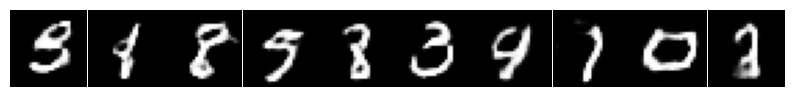

Displaying generated images at the end of epoch 69


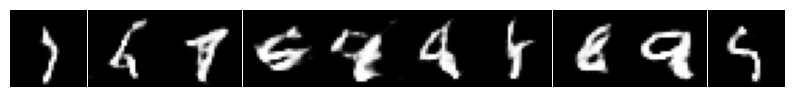

Displaying generated images at the end of epoch 70


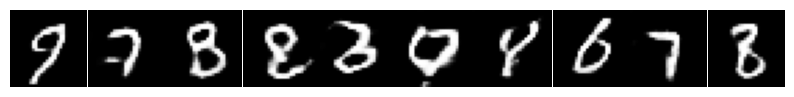

Displaying generated images at the end of epoch 71


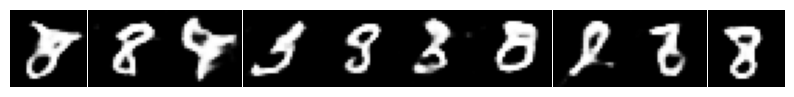

Displaying generated images at the end of epoch 72


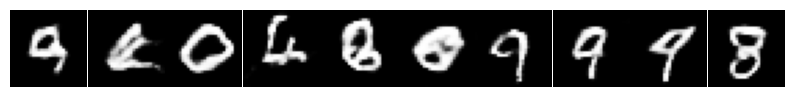

Displaying generated images at the end of epoch 73


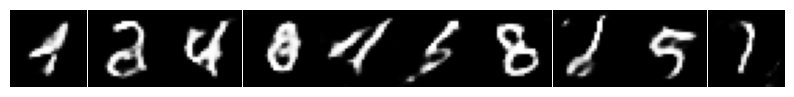

Displaying generated images at the end of epoch 74


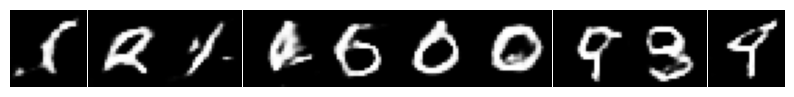

Displaying generated images at the end of epoch 75


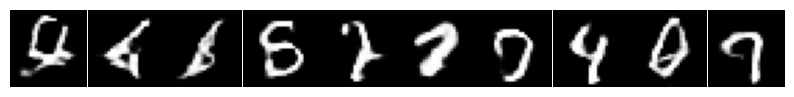

Displaying generated images at the end of epoch 76


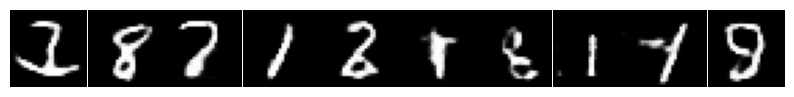

Displaying generated images at the end of epoch 77


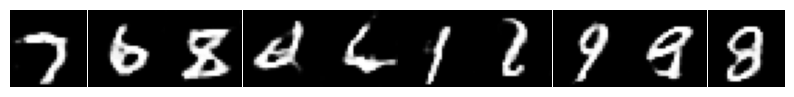

Displaying generated images at the end of epoch 78


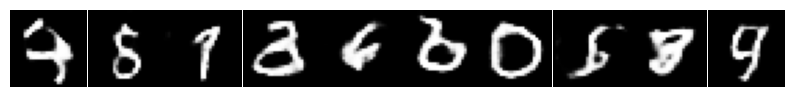

Displaying generated images at the end of epoch 79


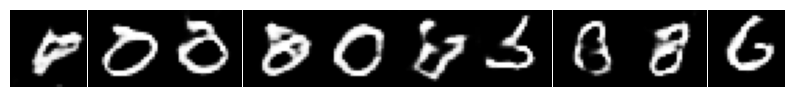

Displaying generated images at the end of epoch 80


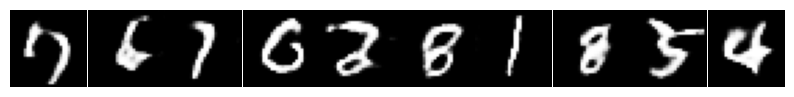

Displaying generated images at the end of epoch 81


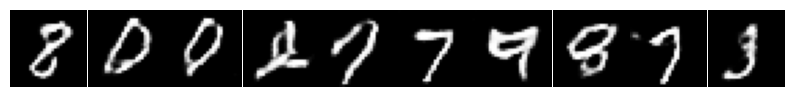

Displaying generated images at the end of epoch 82


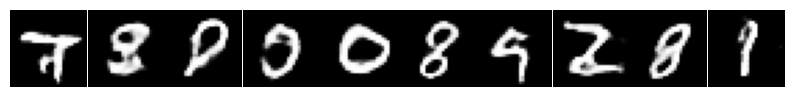

Displaying generated images at the end of epoch 83


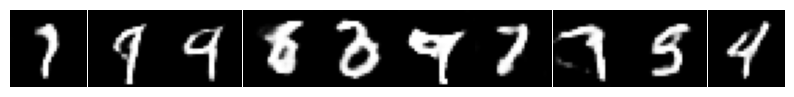

Displaying generated images at the end of epoch 84


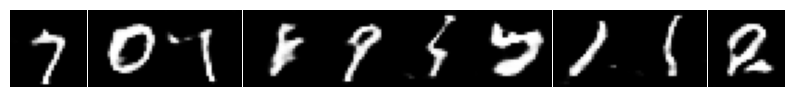

Displaying generated images at the end of epoch 85


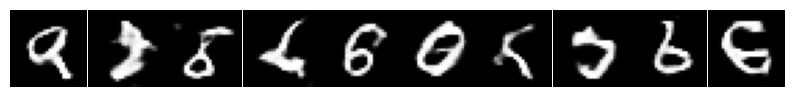

Displaying generated images at the end of epoch 86


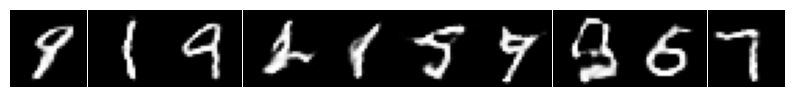

Displaying generated images at the end of epoch 87


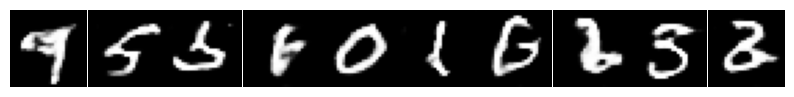

Displaying generated images at the end of epoch 88


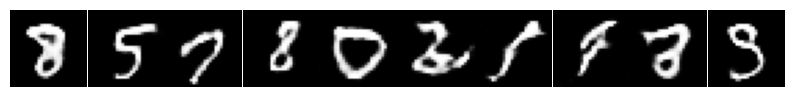

Displaying generated images at the end of epoch 89


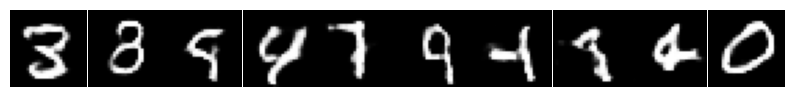

Displaying generated images at the end of epoch 90


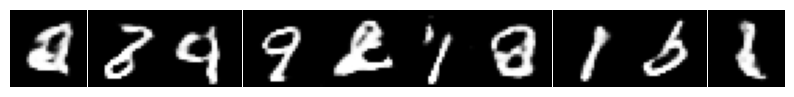

Displaying generated images at the end of epoch 91


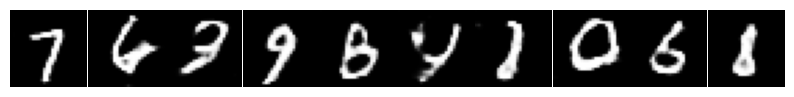

Displaying generated images at the end of epoch 92


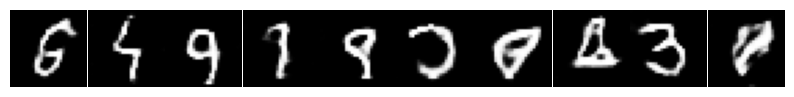

Displaying generated images at the end of epoch 93


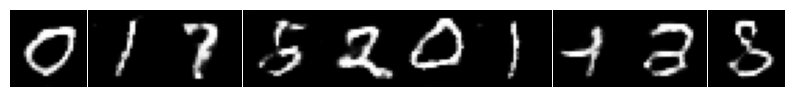

Displaying generated images at the end of epoch 94


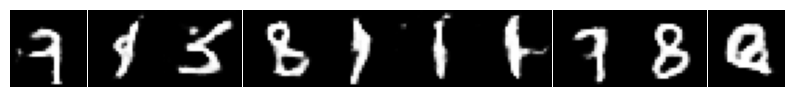

Displaying generated images at the end of epoch 95


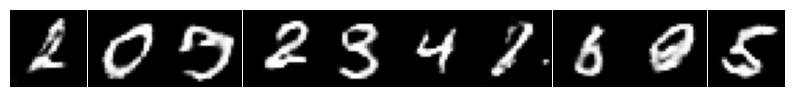

Displaying generated images at the end of epoch 96


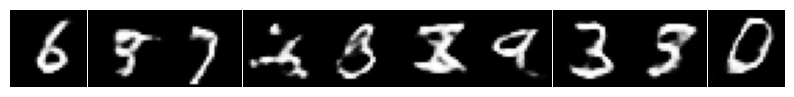

Displaying generated images at the end of epoch 97


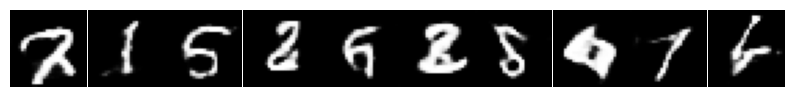

Displaying generated images at the end of epoch 98


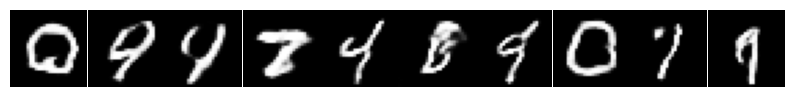

Displaying generated images at the end of epoch 99


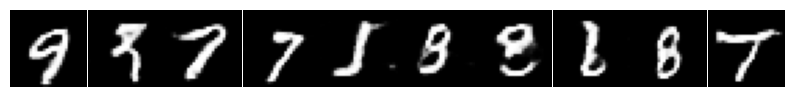

Displaying generated images at the end of epoch 100


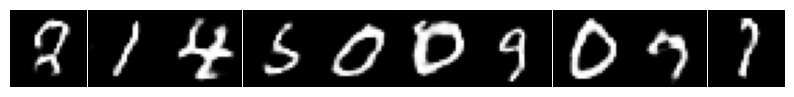

In [22]:
# Train the models
train(generator, discriminator, train_dataset, epochs=100, batch_size=batch_size, z_dim=z_dim)